In [8]:
import sys
##### SET TO PATH ON LOCAL SYSTEM
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import argrelextrema

import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

from jupyterthemes import jtplot
#jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)
torch.set_num_threads(4)
np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:6'

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


### Create Signal

In [9]:
FREERUN = 20  # Extra predicition time-steps after test data
deltaT = .02      # Number of extra free-running steps  int(20/.02) 

rho = 28.0
sigma = 10.0
beta = 8/3

# Lorenz 1963
def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]             # Initial point
t = np.arange(0,300+FREERUN,deltaT)  # Total of 320 full steps with deltaT=.02
states = odeint(f,state0,t)

mu = np.mean(states, axis=0)       # Get mean for each of x,y,z
signal = (states - mu)[:,[0,1,2]]  # Mean center the data
M = signal.shape[0] - int(FREERUN/deltaT)  # Length of train plus test... no freerun
K = 3                                  # Input dimension
L = 3                                  # Output dimension
RF = .5                                # For feedback <--- not implemented
TEST = 1000                            # length of test
LEAD = 100                            # Number of points to plot before test
BURNIN = 100                           # Number of steps ignored for random x0 to fade
REG = 1e-8                             # Regularization factor for ridge regression
TRAINLENGTH = M-TEST    

MINMAXS = np.max(signal[:TRAINLENGTH+TEST],axis=0)-np.min(signal[:TRAINLENGTH+TEST],axis=0)
STD = np.std(signal[:TRAINLENGTH+TEST],axis=0)
RGS = [(-19.5,19.5),(-27,27),(-25,25)]
BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value MM is {MINMAXS}')
print(f'std = {STD}')

Signal length M=15000
Normalizing value MM is [38.05303465 52.5343247  46.87228953]
std = [7.9122292  8.99288317 8.56681415]


### Helper functions and plotting parameters

In [10]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)
    


fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### Loading and saving dicts

In [11]:
#with open('Dicts/diagL3D.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsL3D.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

fpath = 'Dicts0/diagL3D.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts0/modelsL3D.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

### Plot low-error model counts by size

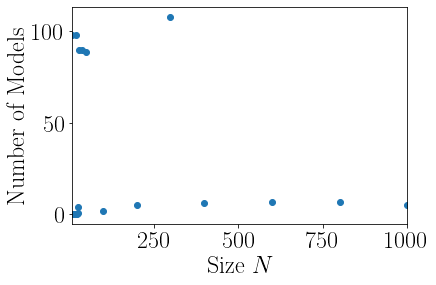

In [12]:
size = [1000, 800, 600, 400, 300, 200, 100,
        50, 40, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12,10]

mean_errors = []
num_models = []
for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)
np.save('num_modelsL3D_2',num_models)

plt.scatter(size[::-1],num_models[::-1])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.show()

Skipped 12
Skipped 13
Skipped 15
Skipped 16
Skipped 17
Skipped 18


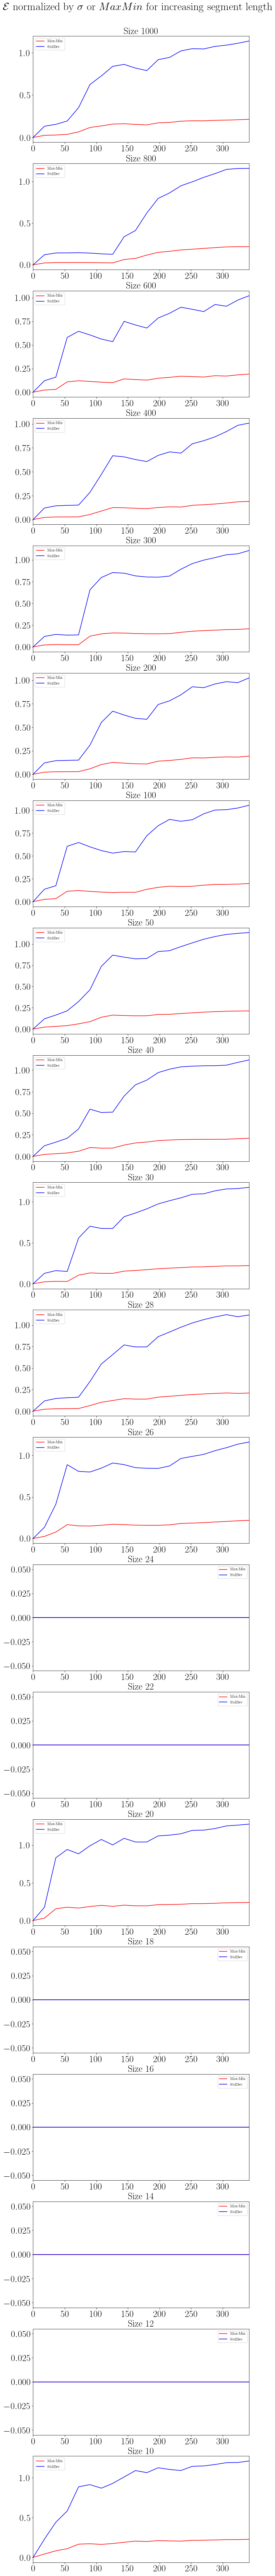

In [15]:
import pdb
def debug():
    #pdb.set_trace()
    Nplots= len(size)
    Nsegs = 20
    stpsz = 100
    segment_errMM = np.zeros((Nplots,Nsegs))
    segment_errSTD = np.zeros((Nplots,Nsegs))
    seglengths = np.zeros((1,Nsegs))
    for n in range(Nplots):
        try:
            preds = np.squeeze(np.array(dict_models[str(size[n])]['Preds']))
        except:
            print(f'Skipped {n}')
            continue
        for i in range(1,Nsegs):
            #print(f'{n}   {i}')
            sigchk = signal[TRAINLENGTH:TRAINLENGTH+i*stpsz]
            predschk = preds[TRAINLENGTH:TRAINLENGTH+i*stpsz]
            predschk = np.nan_to_num(predschk, nan=100)
            errMM = rca.NRMSE(sigchk,
                              predschk,
                              MINMAXS)
            errSTD = rca.NRMSE(sigchk,
                               predschk,
                               STD)
            segment_errMM[n,i] = np.mean(errMM)
            segment_errSTD[n,i] = np.mean(errSTD)
            seglengths[0,i] = i*18

    fig, axs = plt.subplots(Nplots, figsize=(10,6*Nplots)) 
    fig.suptitle('$\mathcal{E}$ normalized by $\sigma$ or $MaxMin$ for increasing segment length'
                 , y=.89, fontsize=28)
    for n in range(Nplots):
        axs[n].set_title(f'Size {size[n]}')
        axs[n].plot(seglengths[0,:], segment_errMM[n,:],
                 color='r', label=f'Max-Min')
        axs[n].plot(seglengths[0,:], segment_errSTD[n,:],
                 color='b', label=f'StdDev')
        axs[n].legend()
    #fig.tight_layout()
    plt.show()
    
debug()

In [ ]:
#np.save('mean_errorL3D_2', mean_errors)

### 2D plots of target with prediction

In [ ]:
variable = ['X','Y','Z']

Nplots = len(size)

for n in range(Nplots):
    try:
        count  = dict_diag[str(size[n])]['numModels']
    except:
        count = 0
    if((count == 0) or (count == None)):
        continue
    preds = np.array(dict_models[str(size[n])]['Preds'])
    fig, ax = plt.subplots(3, figsize=(10,8), sharex=True)
    for sp in range(3):
        ax[sp].set_title(f'{variable[sp]} Predictions')

        error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST,sp],
                              MINMAXS[sp])
        kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp],
                                    preds[TRAINLENGTH:TRAINLENGTH + TEST,sp],
                                     np.min(signal[:TRAINLENGTH+TEST,sp]),
                                     np.max(signal[:TRAINLENGTH+TEST,sp]),
                                     bins=50)
        ekl = error_testset*kl
        print(f' N={size[n]} Dim={sp}  Error = {error_testset.round(2)} KL-div = {np.round(kl,2)} ekl = {np.round(kl,2)}')
        ax[sp].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp], color='k',label='target', alpha=0)
        if(sp==2):
            ax[sp].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp], color='k')
            ax[sp].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST,sp], label=f'N={size[n]}')
        else:
            ax[sp].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST,sp], color='k')
            ax[sp].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST,sp])
    plt.legend(bbox_to_anchor=(1.11, 2.05))
    plt.show()
    plt.close()

### Calculate Rank Method-1 for all sizes

In [ ]:
tols = [1/10**x for x in range(5,20)]

from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)
#def test():
all_ranks = []
K = 3
L = 3
tols = [1/10**x for x in range(5,20)]
plt.figure()
for n in size:
    #pdb.set_trace()
    n = str(n)
    try:
        count  = dict_diag[n]['numModels']
    except KeyError:
        count = 0
    
    if(not count):
        all_ranks.append(0)
        continue

    mat = np.array(dict_models[n]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,int(n), matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    sr = p[1]
    
    x0 = np.zeros((int(n),1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(2)}')
    print(f'Alpha {np.round(a,2)} --- Rho {np.round(sr,2)}\n')
    all_ranks.append(ave_rank)
plt.title('Rank vs Tolerance for various size $N$')
plt.xlabel('Tolerance $\epsilon > 10^{-x}$')
plt.ylabel('$\mathrm{rank(C_{N};\epsilon)}$')
plt.legend(loc='upper right')
plt.ylim(0,50)
plt.show()

In [ ]:
#np.save('ranksL3D_2',all_ranks)

### Log-Log Plot Rank Method-1 vs Size

In [ ]:
plt.loglog(size[::-1],all_ranks[::-1], label='indicated')
plt.loglog(size[::-1],size[::-1], label='N')
plt.xlabel('Size $N$')
plt.ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

### 3D Plot

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from scipy.signal import argrelmax

In [ ]:
N = 30
K = 3
v = 0
pred = np.array(dict_models[str(N)]['Preds'])
start, end= 13900,15000
p = dict_models[str(N)]['Params']
mat = np.array(dict_models[str(N)]['Wnet'])
Wr, Wi = rca.get_mats(None, K,N, matrix=mat)
sig_rks,radii = rca.rank_along_trajectory( Wr, Wi, p[0], p[2],
                            signal[start:end], N, K, tols[v])
pred_rks,_ = rca.rank_along_trajectory( Wr, Wi, p[0], p[2],
                            pred[start:end],N, K, tols[v])

top,bottom  = 13900,15000
mu = np.array([.56018255, .55704211, 23.59124571])

gs = gridspec.GridSpec(2, 1, hspace=.01)
fig = plt.figure(figsize=(12,24))
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot(signal[14000:,0]+mu[0],
         signal[14000:,1]+mu[1],
         signal[14000:,2]+mu[2],
         c='k', label='$L3D$')
ax1.plot(pred[14000:,0]+mu[0],
         pred[14000:,1]+mu[1],
         pred[14000:,2]+mu[2],
         c='r', label='$\widehat{\mathbf{y}},\enspace N=30$', alpha=.5)
ax1.set_xlabel('$v^{(1)}_t$', fontsize=26, color='black')
ax1.set_ylabel('$v^{(2)}_t$', fontsize=26, color='black')
ax1.set_zlabel('$v^{(3)}_t$', fontsize=26, color='black')
ax1.w_xaxis.set_pane_color ((0., 0., 0., 0.))
ax1.w_yaxis.set_pane_color ((0., 0., 0., 0.))
ax1.w_zaxis.set_pane_color ((0., 0., 0., 0.))
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20
ax1.zaxis.labelpad = 20
ax1.set_zticklabels([10,20,30,40])
ax1.legend(fontsize=24,
           labelcolor='black',
           ncol=2,
           handlelength=.5,
           borderpad=.2,
           borderaxespad=.2)
ax1.text(-.2, 1.,310,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

gs1 = gs[1].subgridspec(2,1, hspace=.02)
ax2 = plt.subplot(gs1[0])
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot([x for x in range(top,bottom-500)],signal[top:bottom-500, 0], color='k', label='$v^{(1)}_t$')
#ax2.plot([x for x in range(top,bottom-500)],signal[top:bottom-500, 2], color='m',
#          linestyle='solid', alpha=.7, label='$v^{(3)}_t$')
ax2.plot([x for x in range(top,bottom-500)],pred[top:bottom-500, 0],'r', ms=3, label = '$\widehat{y}^{(1)},\enspace N=30$')
ax2.axvline(top+100, color='k', linestyle='dashed')
ax2.axvline(top+100+412, color='r', linestyle='dashed')
ax2.set_ylabel('$v^{(1)} -\mu_{v^{(1)}}$', labelpad=10)
ax2.set_ylim(-25,25)
ax2.legend(loc='upper right',
           ncol=3 ,
           handlelength=.5,
           fontsize=22,
           borderpad=.2,
           borderaxespad=.2)
ax2.set_xticks([])
lowlim, uplim =17,28
ax3 = plt.subplot(gs1[1])
ax3.plot([x for x in range(top,bottom-500)],
         sig_rks[:-500].astype(int), color='k',
         label='$L3D$', alpha=.8)
ax3.plot([x for x in range(top,bottom-500)],
         pred_rks[:-500].astype(int), color= 'r',
         label='$\widehat{\mathbf{y}},$ $N=30$', alpha=.6)

ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{30})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax3.legend(handlelength=.5,
           ncol=2,
           loc='lower right',
           fontsize=22,
           borderpad=.2,
           borderaxespad=.2)
ax3.set_xticks([13900,14000,14100,14200,14300,14400])
ax3.set_xticklabels([-100,0,100,200,300,400])
ax3.set_yticks([20,25])
ax3.set_yticklabels([20,25])
ax2.vlines(np.where(radii[:-500]>1.3)[0]+13900 , -25,25, color='k', linewidths=1, alpha=.15)
ax3.vlines(np.where(radii[:-500]>1.3)[0]+13900 , lowlim,uplim, color='k', linewidths=1, alpha=.15)
ax3.axvline(top +100, color='k', linestyle='dashed')
ax3.axvline(top +100+412, color='r', linestyle='dashed')
ax3.set_ylim(lowlim,uplim)
plt.tight_layout()
plt.show()

fig.savefig("Submission/Fig4.png", format='png',dpi=300, bbox_inches='tight', pad_inches=.01)
fig.savefig("Submission/Fig4.pdf", format='pdf',dpi=300, bbox_inches='tight', pad_inches=.01)

### Get time-step of divergence

In [ ]:
div_mats = []
threshs = []
locs = []

def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

FREE =1000
T = M + FREE
DIMS = K
Nplots = len(size)
for i in range(Nplots):
    correlations = np.zeros((DIMS,T))
    thresholds = np.zeros(DIMS)
    threshold_location = np.zeros(DIMS, dtype=int)
    k = size[i]
    try:
        count  = dict_diag[str(size[i])]['numModels']
    except:
        count = 0
    if(count == 0):
        continue
    for i in range(DIMS):
        corr_length = T-k # calculate for j= 0,..., M-k
        pred = np.array(dict_models[str(size[i])]['Preds']) # Get size N predictions

        for j in range(corr_length):
            tar = signal[j:j+k,i].reshape((k,1))
            prd = pred[j:j+k,i].reshape((k,1))
            correlations[i,j] = Rxy(tar,prd)

        minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
        thresholds[i] = minVal*.95
        threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
        print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
              f' Location={threshold_location[i]}')
    print('\n')
    div_mats.append(correlations)
    threshs.append(thresholds)
    locs.append(threshold_location)

### Plot divergence

In [ ]:
start = TRAINLENGTH - 1000
stop = M+FREERUN

Nplots = len(div_mats)

for n in range(Nplots):
    try:
        count  = dict_diag[str(size[n])]['numModels']
    except:
        count = 0
    if(count == 0):
        continue
    fig, ax = plt.subplots(3, figsize=(10,9))
    print(f'N={size[n]}')
    trainCorr = div_mats[n]
    thresholdLoc = locs[n]
    for sp in range(3):
        mx = np.max(np.abs(signal[:TRAINLENGTH,sp]))
        print(f'N {size[n]} corr {trainCorr.shape}')
        ax[sp].plot(div_mats[n][sp,TRAINLENGTH:TRAINLENGTH+TEST], color='r', label=f'k={k}')
        ax[sp].plot(signal[TRAINLENGTH:TRAINLENGTH+TEST,sp]/mx, color='k', label='target')
        ax[sp].plot(pred[TRAINLENGTH:TRAINLENGTH+TEST,sp]/mx, label='pred')
        ax[sp].axvline(thresholdLoc[sp],color='r',
                       linestyle='dashed',label='diverged')
        ax[sp].axhline(threshs[n][sp],linestyle='dotted',color='r')
        #ax[sp].axvline(500,color='k',linestyle='dashed')
        ax[sp].set_ylabel('$\mathbf{R}_{xy}$')
        ax[sp].set_xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
        #ax[sp].set_xticklabels([-500,-250,0,250,500,750])
        plt.legend(fontsize=24,bbox_to_anchor=(1.31, 2.05))
        ax[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
    plt.show()
    plt.close()